In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('ab_dataset.csv')

In [5]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [7]:
df.shape

(294478, 5)

We have a dataset containing user visits, assignments to either a control (old_page) or treatment (new_page) condition, and binary conversions. The primary goal is to ascertain whether the new page yields a statistically significant improvement over the old page in terms of conversion.

In [8]:
conversion_df = pd.crosstab(df['group'], df['converted'])
conversion_df

converted,0,1
group,,
control,129479,17723
treatment,129762,17514


Mismatches: We identified rows where group == 'treatment' but the landing_page == 'old_page', and similarly, rows where group == 'control' but landing_page == 'new_page'. Such anomalies occur during data collection and needs to be removed.

In [9]:
control_new_page = df[(df['group'] == 'control') &(df['landing_page'] == 'new_page')]
treatment_old_page = df[(df['group'] == 'treatment') &(df['landing_page'] == 'old_page')]

print(f'Mismatched Control records are : ', control_new_page.shape)
print(f'Mismatched Treatment records are : ', treatment_old_page.shape)

Mismatched Control records are :  (1928, 5)
Mismatched Treatment records are :  (1965, 5)


In [10]:
df_clean = df[(df['group'] == 'control') &(df['landing_page'] == 'old_page') |
              (df['group'] == 'treatment') &(df['landing_page'] == 'new_page')]

df_clean.shape

(290585, 5)

In [11]:
df_clean.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

We want independent records for each user. Duplicacy may lead to false or incorrect judgement



In [12]:
duplicate_users = df_clean[df_clean['user_id'].duplicated()]
duplicate_users

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Thus dropping the user_id mentioned above and keeping the first time site visit of this user

In [13]:
df_clean = df_clean.drop_duplicates(subset='user_id', keep='first')
df_clean.shape

(290584, 5)

In [14]:
df_clean.tail()

,user_id,timestamp,group,landing_page,converted
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


In [15]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [16]:
import datetime
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])

In [17]:
df_clean['day'] = df_clean['timestamp'].dt.day

In [18]:
df_clean.head()

,user_id,timestamp,group,landing_page,converted,day
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,21
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,12
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,11
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,8
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,21


C:\Users\thaku\AppData\Local\Temp\ipykernel_12180\2447269126.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=conversions.index, y=conversions.values, palette = 'viridis')


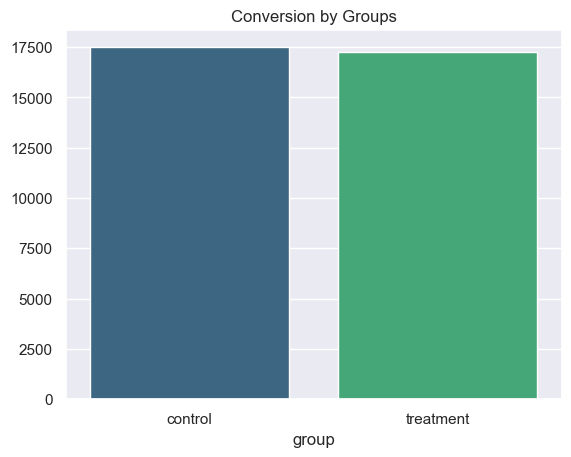

In [19]:
conversions = df_clean.groupby('group')['converted'].sum()
sns.barplot(x=conversions.index, y=conversions.values, palette = 'viridis')
plt.title('Conversion by Groups')
plt.show()

Experimental Setup 

A/B Testing
In the context of A/B testing:

Converted = 1 → The user completed the desired action (like signing up, purchasing, clicking a link, etc.).
Converted = 0 → The user did not complete that action.
This is the target metric or outcome you're testing between two versions — A (control) and B (variant).

Hypothesis Testing
I want to test:

"Is there a significant difference in conversion rates between the two groups?"

Best Test to Use:
Two-Proportion Z-Test
Because:

I am comparing proportions (conversion rate = number of conversions / total users)
Between two independent groups (Group A vs Group B)
And the outcome (converted) is binary (0 or 1)
Why Not Chi-Square?
Chi-Square is good when comparing two categorical variables, like gender vs preference.
But in my case, converted is binary numeric (treated as success/failure), and i am comparing proportions — not distributions across categories.
Hypothesis for the Z-Test:
Null (H₀): Conversion rate of A = Conversion rate of B
Alternative (H₁): Conversion rate of A ≠ Conversion rate of B


In [20]:
old_page_conversion_grp = len(df_clean[(df_clean['group'] == 'control') & df_clean['converted'] == 1])
new_page_conversion_grp = len(df_clean[(df_clean['group'] == 'treatment') & df_clean['converted'] == 1])

old_page_grp = len(df_clean[df_clean['group'] == 'control'])
new_page_grp = len(df_clean[df_clean['group'] == 'treatment'])

from statsmodels.stats.proportion import proportions_ztest

zstat, p_val = proportions_ztest([old_page_conversion_grp, new_page_conversion_grp], [old_page_grp, new_page_grp], value=0,
                                 alternative='two-sided')

print(f"Z stat : {zstat}")
print(f"P value : {p_val}")

if p_val < 0.05:
    print("The conversion rate of control and treatment is significantly different")
else:
    print("There is no difference between conversion rate of control and treatment")
    
old_page_conversion_dist = old_page_conversion_grp/old_page_grp * 100
new_page_conversion_dist = new_page_conversion_grp/new_page_grp * 100

print(f"Control group conversion % count is {old_page_conversion_dist}")
print(f"Treatment group conversion % count is {new_page_conversion_dist}")

Z stat : 1.3109241984234394
P value : 0.18988337448195103
There is no difference between conversion rate of control and treatment
Control group conversion % count is 12.03863045004612
Treatment group conversion % count is 11.880806551510565


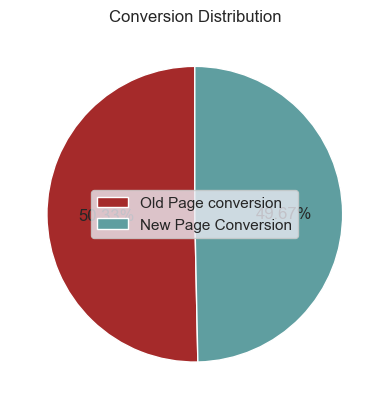

In [21]:
plt.pie(x= [old_page_conversion_dist, new_page_conversion_dist], autopct='%.2f%%', startangle=90, colors =
        ['brown', 'cadetblue'],)
plt.title('Conversion Distribution')
label = ['Old Page conversion', 'New Page Conversion']
plt.legend(label)
plt.show()

Result: Even though the new page had a slightly lower conversion rate, the difference was not statistically significant. That means we can’t say the new page performed better than the old one.
Takeaway: Sometimes what “looks better” doesn’t always work better — testing helps us make smarter decisions backed by data!